# Random Forest Model for Loan Default Prediction

## Author: José Cupertino Ruiz Vargas     
### Selection process for the Data Scientist position at Nubank
### São Paulo - SP

## 0. Instructions

This Jupyter notebook contains both the code and inline explanations of the implemented solution. It is intended to run with a **Python 3 kernel** enhanced with the libraries described in the following table:

| Library      | Version| Reference                         |
|:-------------|:-------|:----------------------------------|
| Python       |  3.6.1 | http://www.python.org             |
| Numpy        | 1.12.1 | http://www.numpy.org              |
| Pandas       | 0.20.1 | http://pandas.pydata.org          |
| Matplotlib   |  2.0.2 | http://matplotlib.org             |
| Seaborn      |  0.7.1 | http://seaborn.pydata.org         |
| Scikit-learn | 0.18.1 | http://scikit-learn.org           |
| Scikit-plot  |  0.2.5 | http://scikit-plot.readthedocs.io |
  
In addition to the introductory part, this notebook contains five section:

  1. Reading the Training Dataset
  2. Feature Engineering
  3. Visualization of Selected Features
  4. Random Forest Classifier
  5. Predictions

## 1. Reading the Training Dataset

The given dataset contains **64592 rows** and **29 columns**, but not all of them will be used for the training the of the machine learning model. The target feature is called **default**, and the remaining attributes include both numerical and categorical types.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
df = pd.read_csv('puzzle_train_dataset.csv', parse_dates=['last_payment','end_last_loan'])
df.shape

(64592, 29)

In [3]:
df.dtypes

ids                           object
default                       object
score_1                       object
score_2                       object
score_3                      float64
score_4                      float64
score_5                      float64
score_6                      float64
risk_rate                    float64
amount_borrowed              float64
borrowed_in_months           float64
credit_limit                 float64
reason                        object
income                       float64
sign                          object
gender                        object
facebook_profile              object
last_payment          datetime64[ns]
end_last_loan         datetime64[ns]
state                         object
zip                           object
channel                       object
job_name                      object
real_state                    object
ok_since                     float64
n_bankruptcies               float64
n_defaulted_loans            float64
n

## 2. Feature Engineering

We start removing the training samples that do not containt **default** information; this first step reduces the number of rows in the training dataset to **59966**. We define a threshold such that only clients with **income** smaller than **300000** enter in the machine learning model. Additionaly, the features **amount_borrowed** and **borrowed_in_months** serve as inputs of the model. 

We also define two new features, **delta_pay** and **delta_loan**, that depend on **last_payment** and **end_last_loan**, respectively. The handling of missing values in the columns **last_payment** and **end_last_loan** is taken into account before engineering the new features.

The justification for the selection of these features is based on the performance of the machine learning algorithm downstream. Our model is able to predict loan defaults with **91%** of accuracy with very few demands in terms of computing and execution time.

In [4]:
df.dropna(axis=0, how='any', subset=['default'], inplace=True); df.shape

(59966, 29)

In [5]:
income_threshold = 300000

features  = ['default','amount_borrowed','borrowed_in_months','income','delta_pay','delta_loan']

In [6]:
def feat_engineering(df, features):
    # Remove outliers
    df = df.query('income < %f' % income_threshold)
    
    # Handle missing values
    min_last_payment, min_end_last_loan  = df.last_payment.min(), df.end_last_loan.min()
    df = df.fillna( {'last_payment':min_last_payment, 'end_last_loan':min_end_last_loan} )
    
    # Create new features
    df['delta_pay']  = ( df.last_payment.max()  - df.last_payment  ).astype('timedelta64[D]')
    df['delta_loan'] = ( df.end_last_loan.max() - df.end_last_loan ).astype('timedelta64[D]')
    
    # Return columns with good features only
    return df.loc[:, features]

In [7]:
X = feat_engineering(df, features)

## 3. Visualization of Selected Features

The figure below shows the selected features in the diagonal of the matrix, while the correlations between the variables correspond to the off-diagonal plots. The plots in the diagonal are normalized to facilitate the visualization of the two classes (default = True or False) in the same place.

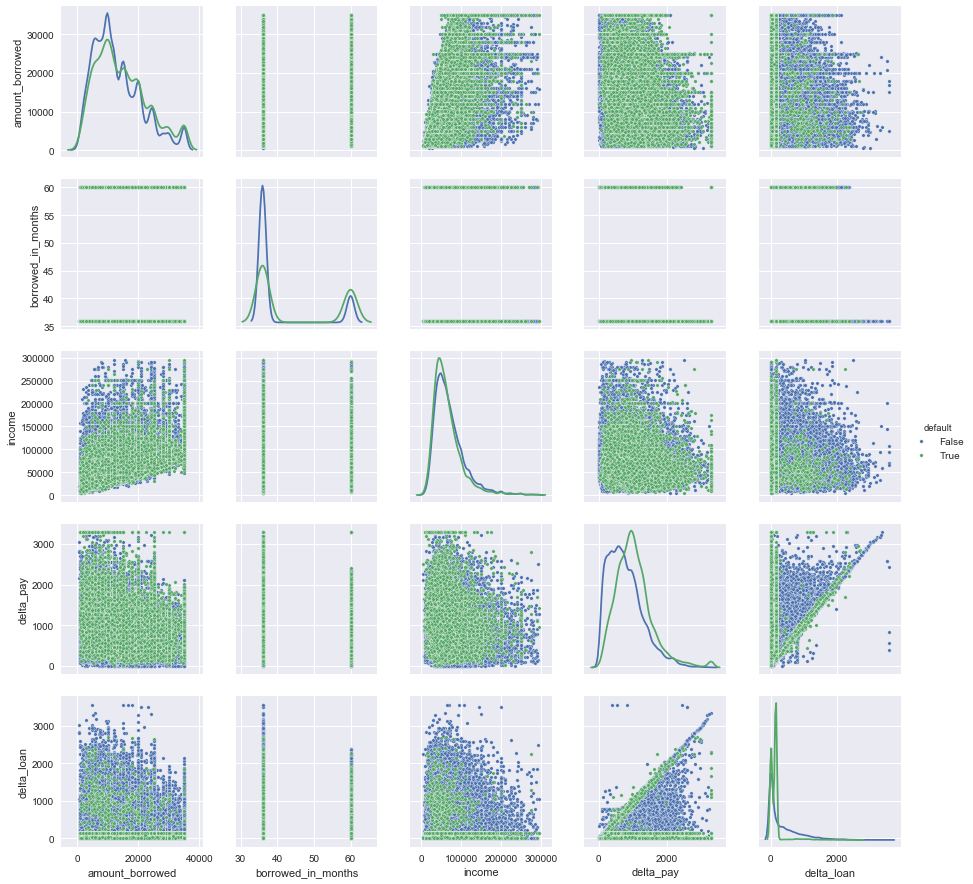

In [8]:
features = features[1:]

sns.pairplot(X, vars=features, hue='default', markers='.', diag_kind='kde');

## 4. Random Forest Classifier

The Random Forest classifier fits a number of decision tree on various sub-samples of the dataset to improve the predictive accuracy. An important parameter of the model is **max_depth** that controls the maximum depth of each tree. In our particular case, we found that **max_dept = 10** provides optimal results.

We compare the performace of Random Forest with a Dummy classifier that simply picks the most frequent class in the training sample. The performace of the model is evaluated by constructing learning curves. For Random Forest we obtain a cross-validation score above **91%**, which is superior to the **84%** score achieved by the dummy classifier.

Regarding the feature importance, the predictive power of **delta_loan** is higher than any other feature, followed by **delta_pay** in second place. The remaining features, **borrowed_in_months**, **income**, and **amount_borrowed**, are in equality of importance.

In [9]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=10, random_state=1);

from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')

from scikitplot import classifier_factory
classifier_factory(model);
classifier_factory(dummy);

In [10]:
y = X['default'].astype('bool')

X.drop('default', axis=1, inplace=True)

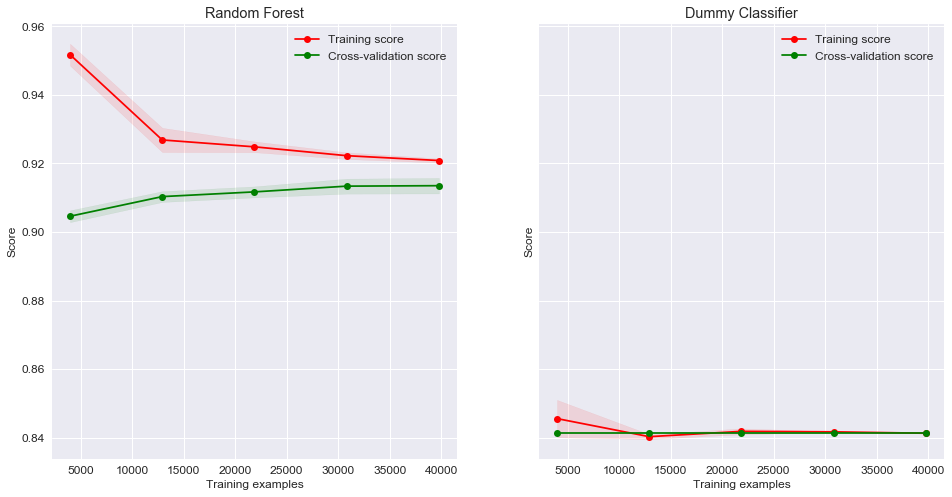

In [11]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(16,8))

model.plot_learning_curve(X, y, ax=ax[0], title='Random Forest');    ax[0].grid()
dummy.plot_learning_curve(X, y, ax=ax[1], title='Dummy Classifier'); ax[1].grid()

In [12]:
model.fit(X, y);

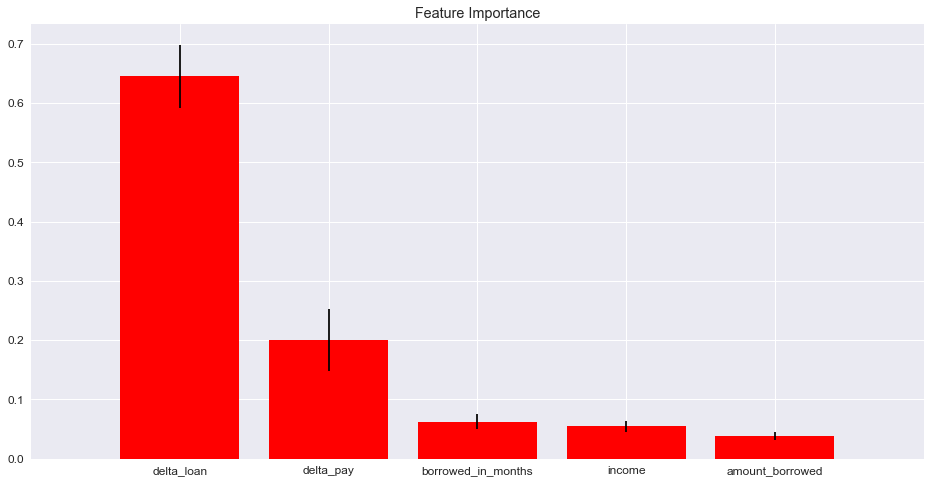

In [13]:
import scikitplot.plotters as skplt

skplt.plot_feature_importances(model, feature_names=features, figsize=(16,8));

## 5. Predictions

We repeat the same feature engineering on the test dataset and use the model trained previouly to make the predictions. The procedure requires a separate treatment for clients with income greater than **300000**. For the time being, we did not train a separate model to cover the extreme situation of the outliers and just set **default = False**, which is a reasonable assumption.

In [14]:
df = pd.read_csv('puzzle_test_dataset.csv', parse_dates=['last_payment','end_last_loan'])
df.shape

(35000, 28)

In [15]:
X = feat_engineering(df, ['ids'] + features)

X['predictions'] = model.predict( X.iloc[:,1:] )

model_prediction = X.loc[:,['ids','predictions']]

In [16]:
outliers = df.loc[ df.income>income_threshold , ['ids'] ]

outliers['predictions'] = np.zeros(outliers.shape[0], dtype=bool)

In [17]:
miss_income = df.loc[ df.income.isnull() , ['ids'] ]

miss_income['predictions'] = np.zeros(miss_income.shape[0], dtype=bool)

Finally, concatenate data frames and write the predictions in a *csv* file:

In [18]:
final_prediction = pd.concat([model_prediction, outliers, miss_income])

In [19]:
final_prediction.to_csv(path_or_buf='predictions.csv', index=False)